In [1]:
import json
import tensorflow as tf
import csv
import numpy as np
import random
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

In [2]:
embedding_dim=100
max_length=16
trunc_type='post'
padding_type='post'
oov_tok='<OOV>'
training_size=160000
test_portion=0.1
corpus=[]

In [3]:
!gdown --id 1wd8KaeCSHxt-nEpMeuHFSNWrDp8joUXJ

Downloading...
From: https://drive.google.com/uc?id=1wd8KaeCSHxt-nEpMeuHFSNWrDp8joUXJ
To: /content/training_cleaned.csv
239MB [00:01, 222MB/s]


In [4]:
num_sentences=0
with open('/content/training_cleaned.csv','r') as csvfile:
  reader=csv.reader(csvfile,delimiter=',')
  next(reader) 
  for  row in reader:
    list_item=[]
    list_item.append(row[5])
    list_label=row[0]
    if list_label=='0':
      list_item.append(0)
    else:
      list_item.append(1)
    num_sentences=num_sentences+1
    corpus.append(list_item)

In [5]:
print(num_sentences)
print(len(corpus))
print(corpus[1])
print(np.array(corpus).shape)

1599999
1599999
['@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds', 0]
(1599999, 2)


In [6]:
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
  sentences.append(corpus[x][0])
  labels.append(corpus[x][1])

tokenizer=Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(sentences)
word_index=tokenizer.word_index
vocab_size=len(word_index)
sequences=tokenizer.texts_to_sequences(sentences)
padded=pad_sequences(sequences,maxlen=max_length,padding=padding_type,truncating=trunc_type)
split=int(training_size*test_portion)
test_sequences = padded[split:]
training_sequences = padded[:split]
test_labels = labels[split:]
training_labels = labels[:split]

In [7]:
print(vocab_size)
print(word_index['i'])

138825
2


In [8]:
!gdown --id 1W5vZy2etitAblLdFn8_DxnsQKzfFJ98g

Downloading...
From: https://drive.google.com/uc?id=1W5vZy2etitAblLdFn8_DxnsQKzfFJ98g
To: /content/glove.6B.100d.txt
347MB [00:01, 210MB/s]


In [9]:
embeddings_index = {};
with open('/content/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [10]:
print(len(embeddings_matrix))

138826


In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64,5,activation='relu'),
    tf.keras.layers.MaxPool1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

training_padded = np.array(training_sequences)
training_labels = np.array(training_labels)
testing_padded = np.array(test_sequences)
testing_labels = np.array(test_labels)

num_epochs = 50
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

print("Training Complete")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 100)           13882600  
_________________________________________________________________
dropout (Dropout)            (None, 16, 100)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 12, 64)            32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3, 64)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 13,947,753
Trainable params: 65,153
Non-trainable params: 13,882,600
_______________________________________

<Figure size 432x288 with 0 Axes>

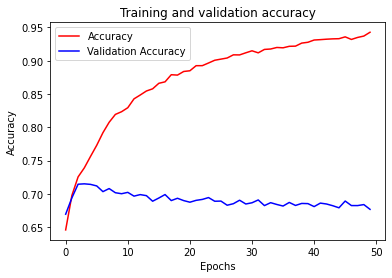

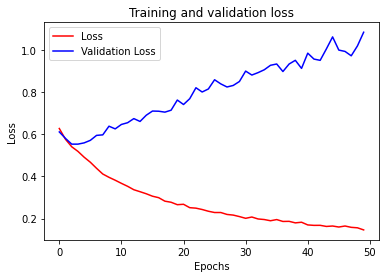

<Figure size 432x288 with 0 Axes>

In [12]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()